In [1]:
#Importando bibliotecas
import os 
import sqlalchemy
from sqlalchemy.sql.elements import Label, collate
import numpy as np
import pandas as pd
from pandas.core.arrays import categorical
from pandas.io.formats.format import TextAdjustment
from pandas.io.pickle import read_pickle
from scipy import sparse
import sweetviz as sv
import matplotlib.pyplot as plt
from sklearn import pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, RandomizedSearchCV
from sweetviz import feature_config
from sklearn.compose import ColumnTransformer
from sklearn import tree, ensemble, svm, neighbors, linear_model, naive_bayes
from sklearn.metrics import roc_curve , classification_report, roc_auc_score
pd.set_option('display.max_columns',100)

In [2]:
# Carregando os paths do banco de dados
dir_local = os.path.dirname(os.path.abspath('__file__'))
dir_project = os.path.dirname(dir_local)
dir_db = os.path.join(dir_project,'Data/olist.db')

In [5]:
# Efetuando a conexão com o SQLAlchemy e carregando o Dataset

con = sqlalchemy.create_engine('sqlite:///'+ dir_db)
load_abt_churn = "SELECT * from tb_abt_no_sells"
dataset = pd.read_sql(load_abt_churn , con)

In [6]:
# Separando a base para OOT(Out of Time) para isto sera colocado a ultima safra em OOT e será trabalhado com os dados restantes para Treino e Teste

safras = dataset['data_lim_safra'].unique()
safras_oot = safras[-2:]

dataset['flag_venda'] = dataset['flag_venda'].astype(int)
df_oot = dataset[ dataset['data_lim_safra'] >= safras_oot[0]].copy()
df = dataset[ dataset['data_lim_safra'] < safras_oot[0]].copy()

In [7]:
# Separando as colunas de features e target e separando os dados entre treino e teste

target = 'flag_venda'
df_columns = df.columns.to_list()
to_remove = ['flag_venda', 'data_lim_safra', 'seller_id']
features = []
for x in df_columns:
    if x not in to_remove:
        features.append(x)

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target],
                                    stratify= df[target], random_state= 200)

In [ ]:
# Carregando o relatório através do SweetViz
# Alguns valores nulos foram encontrados e que serão substituidos pela mediana
#report = sv.analyze(df)
#report.show_html()


In [9]:
# Separando as colunas entre categoricas e numericas

cat_features = df[features].dtypes[df[features].dtypes == 'object'].index.tolist()
num_features = df[features].dtypes[df[features].dtypes !='object'].index.tolist()

In [10]:
""""
 Pipelines
 For numerical features will be applied Simple Imputer replacing missing values with median, then applying MinMax Scaler as preprocessing
 For categorical features will be applied One Hot Encoder
"""

num_enc = Pipeline([('imputer' , SimpleImputer(missing_values= np.nan , strategy='median')),
                    ('scaler', MinMaxScaler())])
preparation = ColumnTransformer( transformers= [
    ('numeric', num_enc, num_features),
    ('categorical' , OneHotEncoder(handle_unknown = 'ignore'), cat_features)])

In [11]:
# Validação Cruzada com alguns Algoritmos a serem usados nas Pipelines

algoritmos = [ 
                # Tree
                tree.DecisionTreeClassifier(),
                tree.ExtraTreeClassifier(),
                # SVM
                svm.LinearSVC(),
                # Neighbors
                neighbors.KNeighborsClassifier(),
                # Naive Bayes
                naive_bayes.BernoulliNB(),
                naive_bayes.GaussianNB(),
                # GLM
                linear_model.LogisticRegression(),
                linear_model.RidgeClassifier(),
                linear_model.SGDClassifier(),
                linear_model.Perceptron(),
                # Ensemble Methods
                ensemble.AdaBoostClassifier(),
                ensemble.BaggingClassifier(),
                ensemble.GradientBoostingClassifier(),
                ensemble.ExtraTreesClassifier(),
                ensemble.RandomForestClassifier()]

#Criando um Dataframe com os resultados assim pode-se comparar os resultados

MLA_cols = ["MLA Name", "MLA Parameters", "MLA Train ROC_AUC Mean", "MLA Test ROC_AUC Mean", "MLA Test ROC_AUC DV Pad", "MLA Time"]
MLA_Compare = pd.DataFrame(columns=MLA_cols)
row_index = 0 # set index

# A métrica utilizada para escolha do melhor algoritmo será a ROC AUC

cv_split = ShuffleSplit(random_state=123)
for algoritmo in algoritmos:
    pipe_loop = Pipeline([  ('prep' , preparation),
                            ('alg' , algoritmo)])
    MLA_name = pipe_loop['alg'].__class__.__name__ # Name of the Algorithm
    print(f"Processando o algoritmo {MLA_name}") 
    MLA_Compare.loc[row_index,"MLA Name"]  = MLA_name
    MLA_Compare.loc[row_index, "MLA Parameters"] = str(pipe_loop['alg'].get_params())
    cv_results = cross_validate(pipe_loop, X= X_train, y= y_train, cv= cv_split, return_train_score=True, n_jobs=-1 , scoring='roc_auc')
    #Resultados da validação cruzada
    MLA_Compare.loc[row_index, "MLA Time"] = cv_results['fit_time'].mean()
    MLA_Compare.loc[row_index, "MLA Train ROC_AUC Mean"] = cv_results['train_score'].mean()
    MLA_Compare.loc[row_index, "MLA Test ROC_AUC Mean"] = cv_results['test_score'].mean()
    MLA_Compare.loc[row_index, "MLA Test ROC_AUC DV Pad"] = cv_results['test_score'].std()*3
    row_index +=1

MLA_Compare.sort_values(by="MLA Test ROC_AUC Mean", ascending=False, inplace=True , ignore_index=True)

Processando o algoritmo DecisionTreeClassifier
Processando o algoritmo ExtraTreeClassifier
Processando o algoritmo LinearSVC
Processando o algoritmo KNeighborsClassifier
Processando o algoritmo BernoulliNB
Processando o algoritmo GaussianNB
Processando o algoritmo LogisticRegression
Processando o algoritmo RidgeClassifier
Processando o algoritmo SGDClassifier
Processando o algoritmo Perceptron
Processando o algoritmo AdaBoostClassifier
Processando o algoritmo BaggingClassifier
Processando o algoritmo GradientBoostingClassifier
Processando o algoritmo ExtraTreesClassifier
Processando o algoritmo RandomForestClassifier


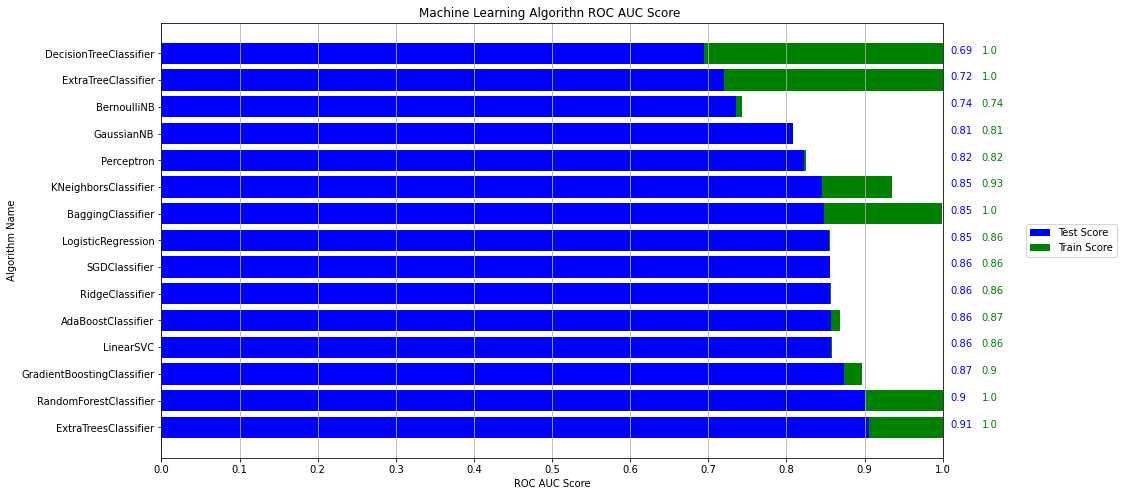

In [12]:
"""
Os resultados mostraram 2 algoritmos com um ROC AUC alto, RF(Random Forest) e ExTrees(Extra Trees),porém os parametros default como:
max_depth = None, 
min_samples_split = 2, 
min_samples_leaf=1

Ambos os resultados foram muito próximos porém estarei optando pelo algoritmo de Extra Trees pois possui um tempo menor de processamento,
facilitando a proxima etapa de otimização de Hyperparametros

Sera aplicado uma "poda" nos hyperparametros para tornar o algoritmo mais generalista, evitando assim um overfit nesta etapa.

Plotando os resultados
"""
fig, ax = plt.subplots(figsize = (14, 8))
ax.barh(y=MLA_Compare['MLA Name'], width=MLA_Compare['MLA Test ROC_AUC Mean'], color = 'b' , label = 'Test Score')
ax.barh(y=MLA_Compare['MLA Name'], width=MLA_Compare['MLA Train ROC_AUC Mean']-MLA_Compare['MLA Test ROC_AUC Mean'], color = 'g', label = "Train Score", left=MLA_Compare['MLA Test ROC_AUC Mean'] )
for index, data in enumerate(MLA_Compare['MLA Test ROC_AUC Mean']):
    plt.text(x=1.01 , y = index, s=MLA_Compare['MLA Test ROC_AUC Mean'][index].round(2) ,color = "b")
    plt.text(x=1.05 , y = index, s=MLA_Compare['MLA Train ROC_AUC Mean'][index].round(2), color = "g")
plt.xlim(0,1)
ax.grid(axis="x")
plt.ylabel("Algorithm Name")
plt.xlabel("ROC AUC Score")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title('Machine Learning Algorithn ROC AUC Score ')
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.show()

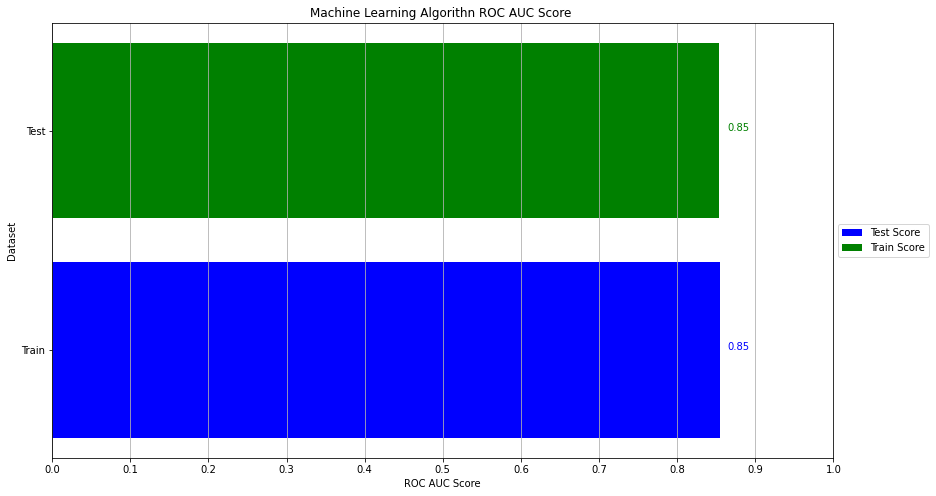

In [13]:
"""
Serão aplicados alguns parametros para realizar uma poda na árvore de decisão aparentemente o algoritmo esta sofrendo de overfit
2 % on min_samples leaf and split 
25 de max depth
"""

reduce_overfit_params = {  "min_samples_split" : 0.02, 
                            "min_samples_leaf" : 0.02,
                            "max_depth" : 25}
pipeline_Ex_tree = Pipeline([   ('prep' , preparation),
                                ('alg' , ensemble.ExtraTreesClassifier(**reduce_overfit_params))])
cv_results_stp1 = cross_validate(pipeline_Ex_tree, X= X_train, y= y_train, cv= cv_split, return_train_score=True, n_jobs=-1 , scoring='roc_auc')
## FAZER o Gráfico novamente

fig1, ax1 = plt.subplots(figsize = (14, 8))
ax1.barh(y="Train", width=cv_results_stp1['train_score'].mean(), color = 'b' , label = 'Test Score')
ax1.barh(y="Test", width=cv_results_stp1['test_score'].mean(), color = 'g', label = "Train Score" )
plt.text(x=cv_results_stp1['train_score'].mean()+0.01 , y = "Train", s=cv_results_stp1['train_score'].mean().round(2) ,color = "b")
plt.text(x=cv_results_stp1['test_score'].mean()+0.01 , y = "Test", s=cv_results_stp1['test_score'].mean().round(2), color = "g")
plt.xlim(0,1)
ax1.grid(axis="x")
plt.ylabel("Dataset")
plt.xlabel("ROC AUC Score")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title('Machine Learning Algorithn ROC AUC Score ')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# O Modelo com os parametros se mostrou mais condizente em treino e teste

In [16]:
def report(y_true, y_pred, title= None):
    print(title)
    print(classification_report(y_true, y_pred))

def plot_roc_curve(fpr, tpr, titulo = None):
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title("Curva ROC")
    plt.legend(title = "Base de dados", )
    plt.plot(fpr, tpr, label = titulo)
    plt.show()

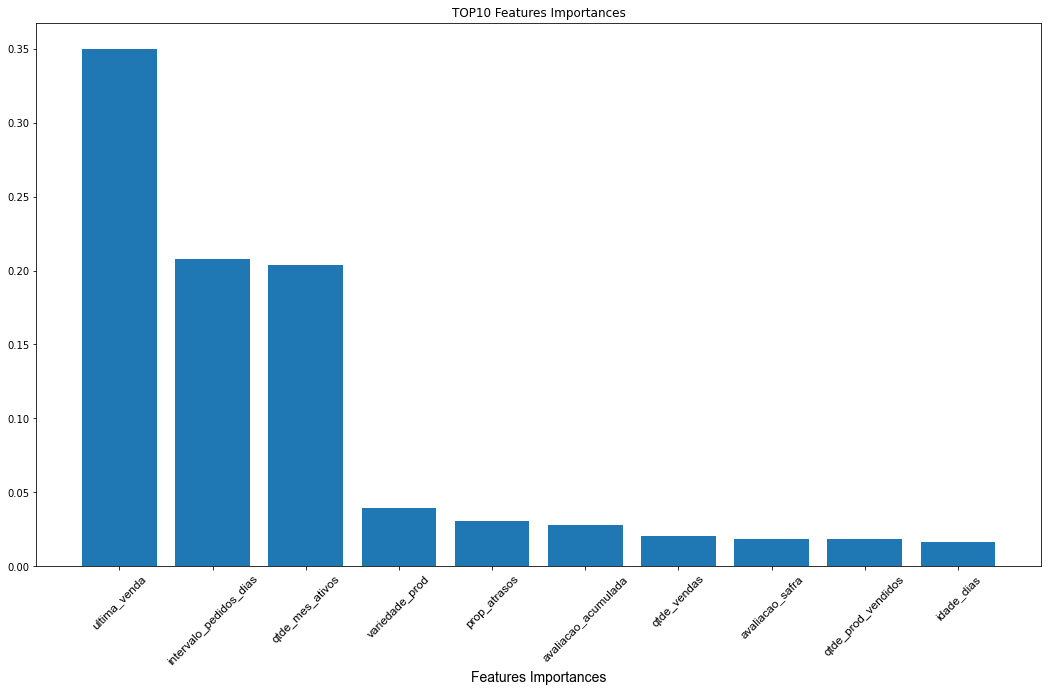

In [14]:
"""
Plotando as variaveis de importancia
Algumas coisas são bem interessantes, as 3 primeiras colunas tem uma forte de relação
a constancia entre os pedidos e atividade do vendedor
Variaveis que tambem foram importantes foram a avaliação do vendendor na safra e qual a
variedade de produtos vendidos.
"""
pipeline_Ex_tree.fit(X_train[features], y_train)
features_values  = pipeline_Ex_tree['alg'].feature_importances_
cat_col_names = list(pipeline_Ex_tree.named_steps['prep'].transformers_[1][1].get_feature_names(cat_features))
col_names = num_features + cat_col_names
features_importances = pd.Series(index= col_names, data = features_values)
features_importances.sort_values(ascending=False, inplace=True)

#Plotando o TOP10 das Features Importances
ticks_font = {'fontname':'Arial', 'size':'12'}
axis_font = {'fontname':'Arial', 'size':'14'}
fig, ax = plt.subplots(figsize = (18, 10))
ax = plt.bar(x=features_importances.index[:10], height= features_importances.values[:10])
plt.title("TOP10 Features Importances")
plt.xlabel("Features Importances", **axis_font)
plt.xticks(rotation=45, **ticks_font)
plt.show()

Test Dataset
              precision    recall  f1-score   support

           0       0.83      0.29      0.43      1051
           1       0.75      0.97      0.85      2347

    accuracy                           0.76      3398
   macro avg       0.79      0.63      0.64      3398
weighted avg       0.78      0.76      0.72      3398

Out of Time Dataset
              precision    recall  f1-score   support

           0       0.83      0.32      0.47      1164
           1       0.74      0.97      0.84      2261

    accuracy                           0.75      3425
   macro avg       0.78      0.65      0.65      3425
weighted avg       0.77      0.75      0.71      3425

ROC AUC SCORE:
AUC SCORE Test Dataset: 0.8532369399241171
AUC SCORE OOT Dataset: 0.8635734272005058


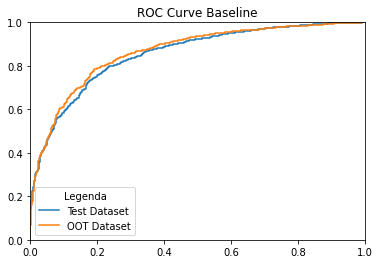

In [17]:
# Resultados com o Dataset de Testes e OOT
# Dataset de Teste
df_test_pred = pipeline_Ex_tree.predict(X_test)
df_test_pred_proba = pipeline_Ex_tree.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, df_test_pred_proba, pos_label=1)
report(y_test, df_test_pred, "Test Dataset")

# OOT Dataset
df_oot_pred = pipeline_Ex_tree.predict(df_oot[features])
pred_oot_proba =  pipeline_Ex_tree.predict_proba(df_oot[features])[:,1]
fpr_oot, tpr_oot, thresh_opt = roc_curve(df_oot[target], pred_oot_proba, pos_label=1)
report(df_oot[target], df_oot_pred , "Out of Time Dataset")

print("ROC AUC SCORE:")
print(f'AUC SCORE Test Dataset: {roc_auc_score(y_test,df_test_pred_proba )}')
print(f'AUC SCORE OOT Dataset: {roc_auc_score(df_oot[target],pred_oot_proba )}')

# Curva ROC com o Dataset de Teste e OOT
roc_test_df = plt.plot(fpr_test, tpr_test, label = "Test Dataset")
roc_oot_df = plt.plot(fpr_oot, tpr_oot, label = "OOT Dataset")
plt.title(label="ROC Curve Baseline")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(title = "Legenda")

In [18]:
# Otimizando os parametros do algoritmo com Randomized Search

min_samples = np.linspace(start=0.02, stop=0.05 )

grid = {    "alg__n_estimators" : [100,200,500,1000],
            "alg__criterion" : ['gini','entropy'],
            "alg__max_depth" : [5,10,15,20,25],
            "alg__min_samples_split" : min_samples,
            "alg__min_samples_leaf" : min_samples}


otimizacao = RandomizedSearchCV(    estimator=pipeline_Ex_tree, param_distributions=grid, 
                                    n_iter=300, n_jobs=-1, cv = cv_split, 
                                    scoring='roc_auc', verbose=3,
                                    random_state=123)
otimizacao.fit(X_train[features], y_train)
resultados = pd.DataFrame(otimizacao.cv_results_)
resultados.sort_values(by='rank_test_score', ascending= True, inplace=True)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 13.4min finished


RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=123, test_size=None, train_size=None),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['idade_dias',
                                                                                'qtde_vendas',
                                                                                'variedade_prod',
          

Utilizando a Base de teste
              precision    recall  f1-score   support

           0       0.81      0.31      0.45      1051
           1       0.76      0.97      0.85      2347

    accuracy                           0.76      3398
   macro avg       0.79      0.64      0.65      3398
weighted avg       0.78      0.76      0.73      3398

Utilizando a Base de OOT
              precision    recall  f1-score   support

           0       0.83      0.35      0.50      1164
           1       0.74      0.96      0.84      2261

    accuracy                           0.76      3425
   macro avg       0.79      0.66      0.67      3425
weighted avg       0.77      0.76      0.72      3425

ROC AUC SCORE:
Optimized AUC SCORE Test Dataset: 0.8513
Optimized AUC SCORE OOT Dataset: 0.862


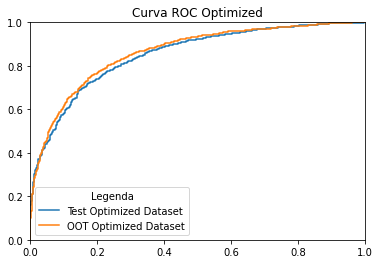

In [19]:
pipeline_Ex_tree.set_params(**otimizacao.best_params_).fit(X_train[features], y_train) # aplicando o melhores parametros do Randomized Search

opt_df_test_pred = pipeline_Ex_tree.predict(X_test)
opt_df_test_pred_proba = pipeline_Ex_tree.predict_proba(X_test)[:,1]
fpr_opt_test, tpr_opt_test, _ = roc_curve(y_test, opt_df_test_pred_proba, pos_label=1)
roc_opt_test = plt.plot(fpr_opt_test, tpr_opt_test, label = "Test Optimized Dataset")
report(y_test,opt_df_test_pred, "Utilizando a Base de teste" )

opt_df_oot_pred = pipeline_Ex_tree.predict(df_oot[features])
opt_df_test_oot_proba = pipeline_Ex_tree.predict_proba(df_oot[features])[:,1]
fpr_oot_test, tpr_oot_test, _ = roc_curve(df_oot[target], opt_df_test_oot_proba, pos_label=1)
roc_opt_oot = plt.plot(fpr_oot_test, tpr_oot_test, label = "OOT Optimized Dataset")
report(df_oot[target],opt_df_oot_pred, "Utilizando a Base de OOT" )

print("ROC AUC SCORE:")
roc_auc_score_test = roc_auc_score(y_test,opt_df_test_pred_proba ).round(4)
roc_auc_score_oot = roc_auc_score(df_oot[target],opt_df_test_oot_proba ).round(4)
print(f'Optimized AUC SCORE Test Dataset: {roc_auc_score_test}')
print(f'Optimized AUC SCORE OOT Dataset: {roc_auc_score_oot}')

# Curva ROC com o Dataset de Teste e OOT
plt.title(label="Curva ROC Optimized")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(title = "Legenda")

In [20]:
# Preparando para o arquivo Pickle

pick = {    "cols_num" : num_features,
            "cat_features" : cat_features,
            "features" : features,
            "target" : target,
            "random_state" : 123,
            "cv_split" : ShuffleSplit(n_splits=10),
            "grid_parametres" : grid,                                         
            "pipeline_algoritmo" : otimizacao.best_estimator_,
            "roc_auc_score_test" : roc_auc_score_test,
            "roc_auc_score_oot" : roc_auc_score_oot}

historical = pd.Series(pick)
print("Creating a Pickle File")
historical.to_pickle(os.path.join(dir_project, 'Modelling/modelo_otimizado.pkl'))

Creating a Pickle File


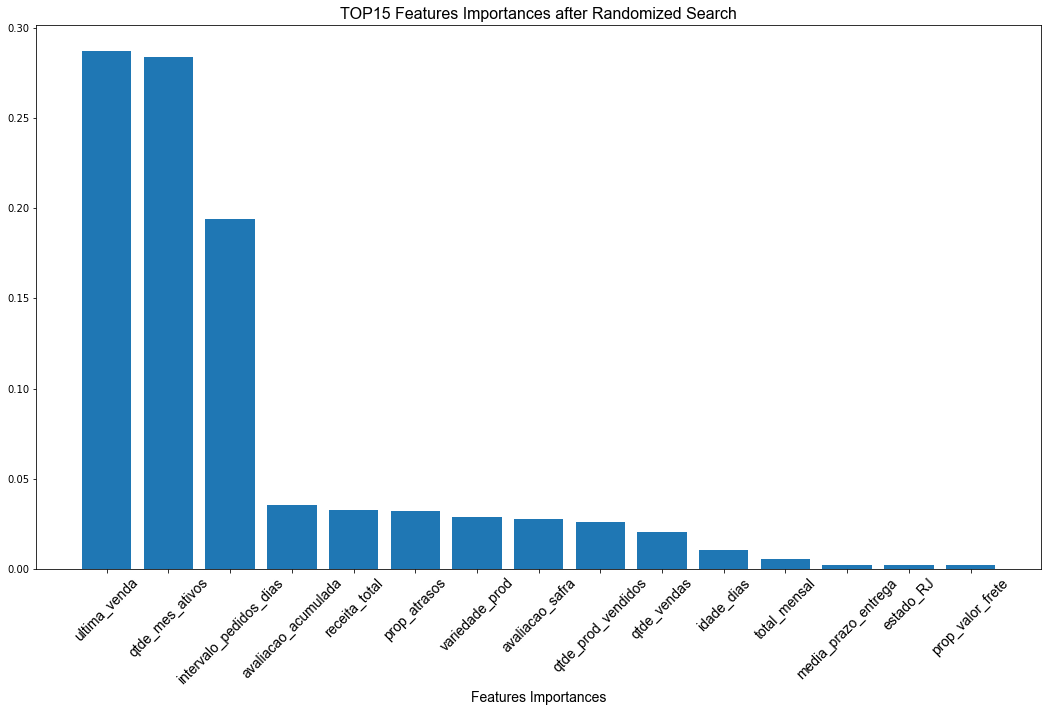

In [21]:
features_values_opt  = pipeline_Ex_tree['alg'].feature_importances_
cat_col_names = list(pipeline_Ex_tree.named_steps['prep'].transformers_[1][1].get_feature_names(cat_features))
features_importances_opt = pd.Series(index= col_names, data = features_values_opt)
features_importances_opt.sort_values(ascending=False, inplace=True)

#Plotting the TOP15 Features Importances
title_font = { 'fontname':'Arial', 'size':'16'}
ticks_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Arial', 'size':'14'}
fig, ax = plt.subplots(figsize = (18, 10))
ax = plt.bar(x=features_importances_opt.index[:15], height= features_importances_opt.values[:15])
plt.title("TOP15 Features Importances after Randomized Search" , **title_font)
plt.xlabel("Features Importances", **axis_font)
plt.xticks(rotation=45, **ticks_font)
plt.show()